# TP3 - Bagging &Boosting
### de Bézenac Emmanuel

## Chargement des données

### Chargement de données bi-dimensionnelles

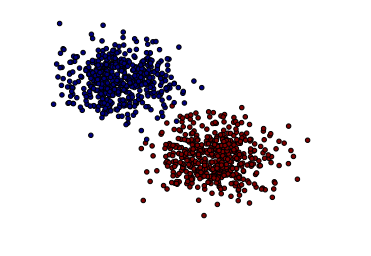

In [230]:
from sklearn import datasets
X_2d, y_2d = datasets.make_blobs(n_samples=1000, n_features=2, centers=2, center_box=(-3, 3))
#X_2d, y_2d = datasets.make_classification(n_classes=3,n_samples=1000, n_clusters_per_class=2, n_features=2, n_redundant=0, n_informative=3)
#X_2d, y_2d = datasets.make_gaussian_quantiles(cov=2.,n_samples=1000, n_features=2,n_classes=2,random_state=1)
#X_2d, y_2d = datasets.make_blobs(n_samples=1000, centers=2, n_features=2, random_state=0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.axis('off')
plt.scatter(X_2d[:,0], X_2d[:,1], c=y_2d)
plt.show()

### Chargement des données MNIST

In [122]:
mnist = datasets.load_digits()
X_mnist = mnist.data
y_mnist = mnist.target

# Bagging

In [92]:
class Estimator(object):
    
    def index_params(self):
        self.params = {p_name:p_value for p_name,p_value in self.__dict__.iteritems()}
    
    def set_params(self, params):
        for p_name, p_value in params.iteritems():
            self.__dict__[p_name] = p_value
            self.params[p_name] = p_value
        
    def get_params(self):
        return self.params
    

In [110]:
import copy
import numpy as np
from sklearn.tree import DecisionTreeClassifier

class BaggingClassifier(Estimator):
    
    def __init__(self, clf=DecisionTreeClassifier(max_depth=1), n_estimators=10, sample_ratio=0.8, plot_decision_boundaries=False, **clf_params):
        self.plot_decision_boundaries = plot_decision_boundaries
        self.n_estimators = n_estimators
        self.sample_ratio = sample_ratio
        self.clf = clf
        self.index_params()
    
    def fit(self, X, y):
        
        #for plotting
        if self.plot_decision_boundaries:
            self.fig = plt.figure(figsize=(15, self.n_estimators/1.5))
            self.fig.suptitle('Decision boundaries of every classifier of ensemble', fontsize=20)
        
        #fitting
        self.idx = []
        self.clfs = []
        m = X.shape[0]
        for i in range(self.n_estimators):
            idx = np.random.choice(range(m), size=int(m*self.sample_ratio), replace=True)
            self.idx.append(idx)
            clf = copy.deepcopy(self.clf)
            clf.fit(X[idx], y[idx])
            self.clfs.append(clf)
            
            #plotting decision boundaries of every classifier
            if self.plot_decision_boundaries:
                plt.subplot(self.n_estimators/4+1, 4, i+1)
                plot_decision_boundary(self.clfs[i], X[idx], y[idx])
                plt.title('classifier n. '+str(i))
    
    def predict(self, X):
        predictions = np.array([clf.predict(X) for clf in self.clfs])
        counts = [np.bincount(p) for p in predictions.T]
        return np.array([np.argmax(c) for c in counts])
        
    def score(self, X, y):
        return np.mean(self.predict(X)==y)


## Préliminaires : Résultats sur données bi-dimensionnelles

#### fonction d'affichage de la frontière de décision d'un classifieur

In [296]:
def plot_decision_boundary(clf, X, y):
    # from a classifier and a two dimensional
    # set of examples X with associated labels
    # y outputs decision boundary
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.axis("tight")
    plt.axis("off")

###  "Tree Stump"

accuracy = 0.942


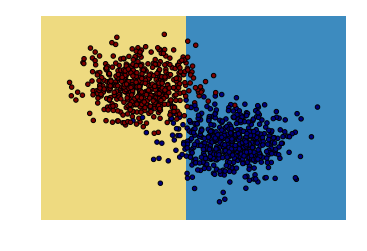

In [205]:
stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_2d, y_2d)
plot_decision_boundary(stump, X_2d, y_2d)
print 'accuracy = '+str(stump.score(X_2d, y_2d))

### Bagging avec classifieurs "Tree Stump"

accuracy = 0.943


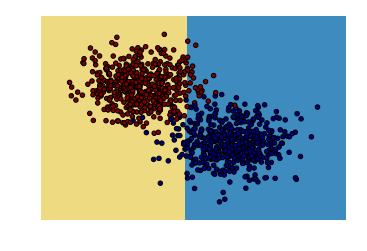

In [389]:
bagging_clf = BaggingClassifier(n_estimators=15, sample_ratio=0.9, max_depth=1)
bagging_clf.fit(X_2d, y_2d)
plot_decision_boundary(bagging_clf, X_2d, y_2d)
print 'accuracy = '+str(bagging_clf.score(X_2d, y_2d))

**Remarque**: La qualité de l'estimateur ne semble pas augmenter lorsque l'on utilise du bagging pour un arbre de décision de profondeur 1. Il serait intéressant de d'observer les différentes décisions apprises pour chaque arbre de l'ensemble.

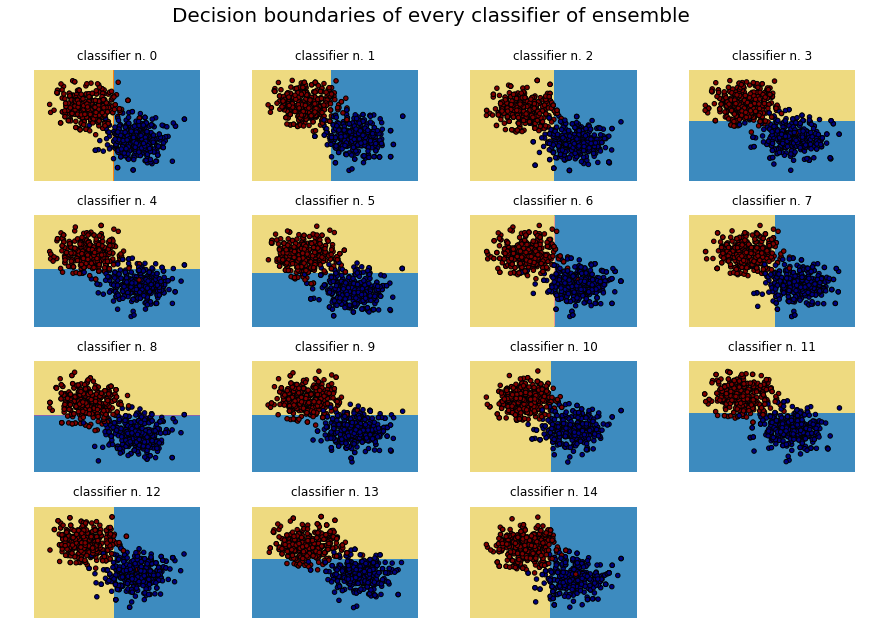

In [210]:
bagging_clf = BaggingClassifier(n_estimators=15, sample_ratio=0.8, plot_decision_boundaries=True)
bagging_clf.fit(X_2d, y_2d)

Il n'y a pas assez de variance entre les décisions extraites par chacun des arbres. Peut-être peut-on corriger ce problème en baissant le nombre d'échantillons que l'on tire pour chaque classifieur; cela pourrait obiger plusieurs classifieurs à effectuer des décisions plus "risquées".

accuracy = 0.969


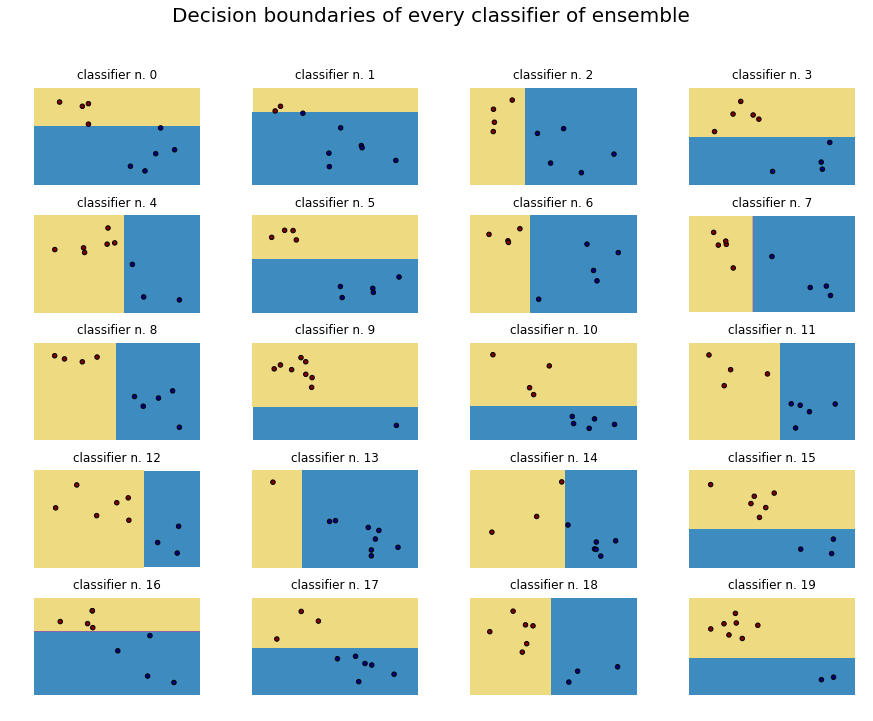

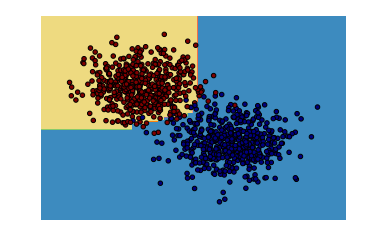

In [228]:
bagging_clf = BaggingClassifier(n_estimators=20, sample_ratio=0.009, plot_decision_boundaries=True)
bagging_clf.fit(X_2d, y_2d)

plt.figure()
plot_decision_boundary(bagging_clf, X_2d, y_2d)
print 'accuracy = '+str(bagging_clf.score(X_2d, y_2d))

* Nous avons vérifié empiriquement que le *bagging* peut construire un classifieur plus expressif que ses classifieurs constituants, et donc faire augmenter le terme de variance et baisser la variance dans la décomposition bais-variance (il faudrait séparer données d'entrainement et données de test pour le démontrer, mais comme nous connaissons la fonction génératrice des données, nous estimons que ce n'est pas nécéssaire içi). Ceci est dû au fait que le *stump* est en *sous-apprentissage* (grand bias, et petite variance) par rapport aux données qui lui sont présentés.


* Mais que ce passe-t-il lorsque nous effectuons du bagging avec des classifieurs avec une grande variance?

### Arbre de décision profond (grande expressivité)

accuracy = 1.0


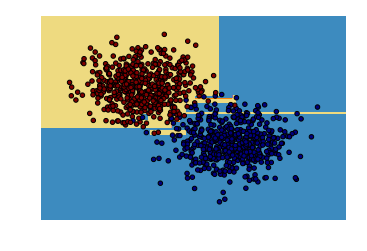

In [229]:
from sklearn.tree import DecisionTreeClassifier
stump = DecisionTreeClassifier(max_depth=20)
stump.fit(X_2d, y_2d)
plot_decision_boundary(stump, X_2d, y_2d)
print 'accuracy = '+str(stump.score(X_2d, y_2d))

L'arbre de décision apprend la base d'apprentissage *par coeur*. Afin de vérifier sont pouvoir de généralisation, il serait intéressant de diviser la base en exemples d'apprentissage et exemples de test. Nous utilisons le principe de *cross-validation*.

In [141]:
def build_folds(X, y, n_cv=5):
    # returns shuffled subsets of initial data
    #according to cross validation method
    
    n = X.shape[0]
    idxs = np.array_split(np.random.randint(1, n, size=n), n_cv)
    Xs, ys, Xs_test, ys_test = [], [], [], []
    for i in range(n_cv):
        folds = range(n_cv)
        test_idx = idxs[folds.pop(i)]
        train_idx = np.concatenate([idxs[fold] for fold in folds])
        Xs.append(X[train_idx])
        ys.append(y[train_idx])
        Xs_test.append(X[test_idx])
        ys_test.append(y[test_idx])
    return Xs, ys, Xs_test, ys_test

def cv_score(clf, folds):
    #fits and scores a classifier clf for 
    #each cross-validation fold
    
    Xs, ys, Xs_test, ys_test = folds
    clfs = [copy.deepcopy(clf) for i in range(len(Xs))]
    [clfs[i].fit(X, y) for i, (X, y) in enumerate(zip(Xs, ys))]
    score = [clfs[i].score(X,y) for i, (X,y) in enumerate(zip(Xs_test, ys_test))]
    return np.mean(score), np.std(score)

In [266]:
folds = build_folds(X_2d, y_2d)
mean, std = cv_score(DecisionTreeClassifier(max_depth=20), folds)
print 'cv accuracy = '+str(mean)+', cv std = '+str(std)

cv accuracy = 0.983, cv std = 0.00509901951359


* Les résultats sont démontrent un surrapprentissage pour l'arbre de décision.


* Testons maintenant le bagging avec ceux-ci:

In [234]:
clf = DecisionTreeClassifier(max_depth=20)
bagging_clf = BaggingClassifier(clf=clf, n_estimators=100, sample_ratio=0.8)
mean, std = cv_score(bagging_clf, folds)
print 'cv accuracy = '+str(mean)+', cv std = '+str(std)

cv accuracy = 0.996, cv std = 0.00374165738677


* L'erreur de généralisation baisse
* La variance sur les folds également

## Suite : Données MNIST

### Arbre de décision profond

In [239]:
folds_mnist = build_folds(X_mnist, y_mnist)
mean, std = cv_score(DecisionTreeClassifier(max_depth=20), folds_mnist)
print 'cv accuracy = '+str(mean)+', cv std = '+str(std)

cv accuracy = 0.923204890127, cv std = 0.00797775384462


### Classe GridSearch

In [147]:
import itertools

class GridSearch(object):
    #this class is based on the GridSearchCV class
    #implemented in sklearn. I reeimplemented it
    #for my ensembles to be compatible
    
    def __init__(self, clf, param_grid, cv=5):
        self.n_cv = cv
        self.clf = clf
        self.param_grid = param_grid
        
    def cartesian(self, dicts):
        return (dict(itertools.izip(dicts, x)) for x in itertools.product(*dicts.itervalues()))    
    
    def build_folds(self, X, y):
        # returns shuffled subsets of initial data
        #according to cross validation method

        n = X.shape[0]
        idxs = np.array_split(np.random.randint(1, n, size=n), self.n_cv)
        Xs, ys, Xs_test, ys_test = [], [], [], []
        for i in range(self.n_cv):
            folds = range(self.n_cv)
            test_idx = idxs[folds.pop(i)]
            train_idx = np.concatenate([idxs[fold] for fold in folds])
            Xs.append(X[train_idx])
            ys.append(y[train_idx])
            Xs_test.append(X[test_idx])
            ys_test.append(y[test_idx])
        return Xs, ys, Xs_test, ys_test
    
    def fit_and_score(self, X, y):
        self.results = []
        Xs, ys, Xs_test,  ys_test = self.build_folds(X, y)
        self.clfs = []
        for params in self.cartesian(self.param_grid):
            scores = np.zeros((self.n_cv))
            scores_train = np.zeros((self.n_cv))
            for fold in range(self.n_cv):
                clf = copy.deepcopy(self.clf)
                clf.set_params(params)
                self.clfs.append(clf)
                clf.fit(Xs[fold], ys[fold])
                scores_train[fold] = clf.score(Xs[fold], ys[fold])
                scores[fold] = clf.score(Xs_test[fold], ys_test[fold])
            self.results.append({'params':params,
                                 'mean':scores.mean(),
                                 'std':scores.std(),
                                 'mean_train':scores_train.mean(),
                                 'std_train':scores_train.std()
                                })
        return self.results

### Fonctions de projection des scores  hyperparamètres en fonction d'un axe

In [157]:
def project_grid_scores(grid_scores, axis):
    # groups scores according to axis and aggregates
    # the the values according to a minima pooling
    
    best = {}
    for s in grid_scores:
        axis_value = s['params'][axis]
        if axis_value not in best:
            best[axis_value] = s
        elif best[axis_value]['mean'] < s['mean'] :
            best[axis_value] = s
    return sorted(best.values(), key=lambda x:x['params'][axis])

def plot_projected_scores(grid_search, ax):
    #from a fitted gridSearch object, calls
    #project_grid_scores function and plots
    #the mean of the results with associated
    #standard deviation
    
    #extracting information from grid_search.results
    results = project_grid_scores(grid_search.results, ax)
    x = grid_search.param_grid[ax]
    mean = np.array([r['mean'] for r in results])
    std = np.array([r['std'] for r in results])
    mean_train = np.array([r['mean_train'] for r in results])
    std_train =np.array([r['std_train'] for r in results])
    
    #plotting information
    plt.figure(figsize=(8, 5))
    plt.title('Scores for '+ax)
    plt.errorbar(x, mean, std, label='mean and variance on Test')
    plt.errorbar(x, mean_train, std_train, label='mean and variances on Train')
    plt.scatter([x[mean.argmax()]], mean.max(), c='r', label='largest value')
    plt.xlabel(ax)
    plt.ylabel('score')
    plt.legend(bbox_to_anchor=(1.1,0.25))
    

### Grid search sur les hyperparamètres du bagging

best parameters: {'std': 0.012788879987497637, 'std_train': 0.00027835768963115905, 'mean_train': 0.99986082115518438, 'params': {'n_estimators': 200, 'sample_ratio': 0.88571428571428557}, 'mean': 0.97327762302692666}


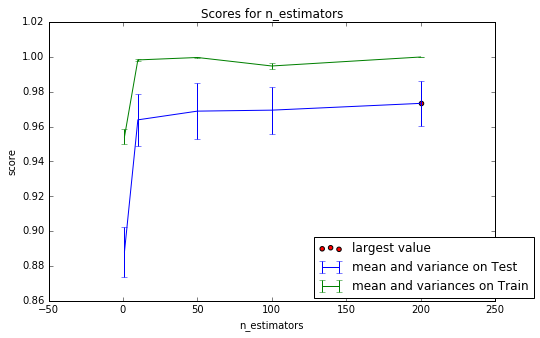

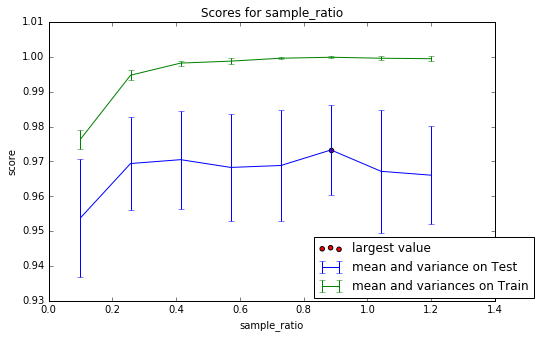

In [159]:

parameter_grid = {
    'n_estimators':[1, 10, 50, 100, 200],
    'sample_ratio':np.linspace(.1, 1.2, 8)
}

#initializing and fitting grid search
clf = DecisionTreeClassifier(max_depth=10)
grid_search = GridSearch(BaggingClassifier(clf=clf), parameter_grid, cv=5)
grid_search.fit_and_score(X_mnist, y_mnist)

#plotting projected scores for n_estimators
plot_projected_scores(grid_search, 'n_estimators')

#plotting projected scores for n_estimators
plot_projected_scores(grid_search, 'sample_ratio')

print 'best parameters: '+str(max(grid_search.results, key=lambda x:x['mean']))

# Boosting

In [ ]:
class BoostingClassifier(object):
    
    def __init__(self, clf=DecisionTreeClassifier(max_depth=1), n_estimators=10):
        self.clfs = [copy.deepcopy(clf) for i in range(n_estimators)]
        self.n_estimators = n_estimators

    def fit(self, X, y):
        m = X.shape[0]
        self.alphas = np.zeros((self.n_estimators))
        w = np.zeros((m))
        w[:] = 1./m
        for t, clf in enumerate(self.clfs):
            clf.fit(X, y, sample_weight=w)
            errors = np.array(clf.predict(X)!=y, dtype='float')
            e = errors.dot(w)
            alpha = 0.5 * np.log((1-e)/e)
            w[errors==0] = w[errors==0]*np.exp(-alpha)
            w[errors==1] = w[errors==1]*np.exp(alpha)
            w = w/np.sum(w)
            self.alphas[t] = alpha
        
    def predict(self, X):
        return np.sign(self.alphas.dot(np.array([clf.predict(X) for clf in self.clfs])))
        
    def score(self, X, y):
        return np.mean(self.predict(X)==y)


In [291]:
class BoostingClassifier(Estimator):
    
    def __init__(self, clf=DecisionTreeClassifier(max_depth=1), n_estimators=10, plot_decision_boundaries=False):
        self.n_estimators = n_estimators
        self.plot_decision_boundaries = plot_decision_boundaries
        self.clf = clf
        self.index_params()
    
    def fit(self, X, y):
        
        #for plotting
        if self.plot_decision_boundaries:
            self.fig = plt.figure(figsize=(15, self.n_estimators/1.5))
            self.fig.suptitle('Decision boundaries of every classifier of ensemble', fontsize=20)
        
        m = X.shape[0]
        self.alphas = np.zeros((self.n_estimators))
        w = np.zeros((m))
        w[:] = 1./m
        self.clfs = []
        for i in range(self.n_estimators):
            clf = copy.deepcopy(self.clf)
            clf.fit(X, y, sample_weight=w)
            errors = np.array(clf.predict(X)!=y, dtype='float')
            e = errors.dot(w)
            alpha = 0.5 * np.log((1-e)/e)
            w[errors==0] = w[errors==0]*np.exp(-alpha)
            w[errors==1] = w[errors==1]*np.exp(alpha)
            w = w/np.sum(w)
            self.alphas[i] = alpha
            self.clfs.append(clf)
            
            #plotting decision boundaries of every classifier
            if self.plot_decision_boundaries:
                plt.subplot(self.n_estimators/4+1, 4, i+1)
                plot_decision_boundary(self.clfs[i], X, y)
                plt.title('classifier n. '+str(i))
        
    def predict(self, X):
        return np.sign(self.alphas.dot(np.array([clf.predict(X) for clf in self.clfs])))
        
    def score(self, X, y):
        return np.mean(self.predict(X)==y)


## Préliminaires : Résultats sur données bi-dimensionnelles

In [300]:
#y [y == 0] -> -1
y_2d_n = np.copy(y_2d)
y_2d_n[y_2d_n==0] = -1
folds_n = build_folds(X_2d, y_2d_n)

### Retour sur le Stump

accurary = 0.982


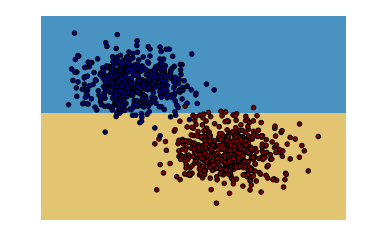

In [310]:
tree = DecisionTreeClassifier(max_depth=1)
tree.fit(X_2d, y_2d_n)
plot_decision_boundary(tree, X_2d, y_2d_n)
print 'accurary = '+str(tree.score(X_2d, y_2d_n))

In [311]:
mean, std = cv_score(DecisionTreeClassifier(max_depth=1), folds_n)
print 'cv accuracy = '+str(mean)+', cv std = '+str(std)

cv accuracy = 0.96, cv std = 0.01


### Résultats avec le Boosting

accuracy = 0.998


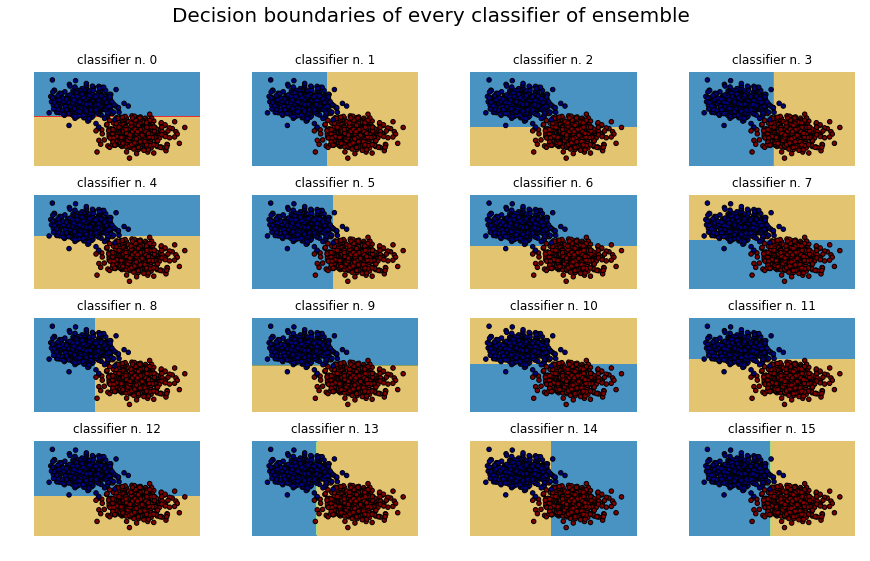

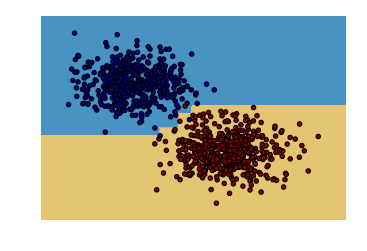

In [298]:
boost = BoostingClassifier(n_estimators=16, plot_decision_boundaries=True)
boost.fit(X_2d, y_2d_n)

plt.figure()
plot_decision_boundary(boost, X_2d, y_2d_n)
print 'accuracy = '+str(boost.score(X_2d, y_2d_n))

In [313]:
mean, std = cv_score(BoostingClassifier(n_estimators=16), folds_n)
print 'cv accuracy = '+str(mean)+', cv std = '+str(std)

cv accuracy = 0.992, cv std = 0.006


** Remarque :** Nous avons, comme pour le bagging, une variance qui baisse, et un biais aussi.

best parameters: {'std': 0.00244948974278318, 'std_train': 0.0, 'mean_train': 1.0, 'params': {'n_estimators': 100}, 'mean': 0.99700000000000011}


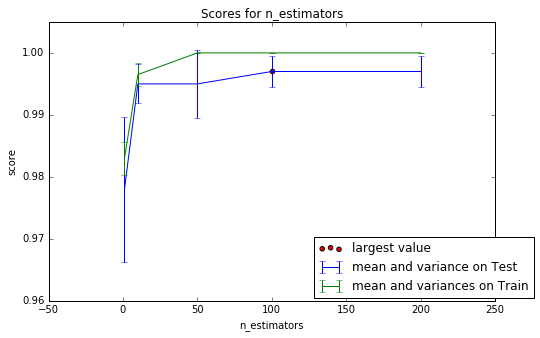

In [315]:

parameter_grid = {
    'n_estimators':[1, 10, 50, 100, 200]
}

#initializing and fitting grid search
grid_search = GridSearch(BoostingClassifier(), parameter_grid, cv=5)
grid_search.fit_and_score(X_2d, y_2d_n)

#plotting projected scores for n_estimators
plot_projected_scores(grid_search, 'n_estimators')

print 'best parameters: '+str(max(grid_search.results, key=lambda x:x['mean']))

## Test sur 2 classes de MNIST

In [340]:
X_mnist_n = np.concatenate([X_mnist[y_mnist==8], X_mnist[y_mnist==9]], axis=0)
y_mnist_n = np.concatenate([y_mnist[y_mnist==8], y_mnist[y_mnist==9]], axis=0)
y_mnist_n[y_mnist_n==8] = -1
y_mnist_n[y_mnist_n==9] = 1
folds_mnist_n = build_folds(X_mnist_n, y_mnist_n)

y_mnist_nn = np.copy(y_mnist_n)
y_mnist_nn[y_mnist_n==-1] = 0
folds_mnist_nn = build_folds(X_mnist_n, y_mnist_nn)

In [349]:
print 'STUMP:'
mean, std = cv_score(DecisionTreeClassifier(max_depth=1), folds_mnist_n)
print 'cv accuracy = '+str(mean)+', cv std = '+str(std)+'\n'

print 'DECISION TREE: DEPTH=20'
mean, std = cv_score(DecisionTreeClassifier(max_depth=20), folds_mnist_n)
print 'cv accuracy = '+str(mean)+', cv std = '+str(std)+'\n'

print 'BAGGING WITH STUMP'
clf = BaggingClassifier(DecisionTreeClassifier(max_depth=1))
mean, std = cv_score(clf, folds_mnist_nn)
print 'cv accuracy = '+str(mean)+', cv std = '+str(std)+'\n'

print 'BAGGING WITH DEEP DECISION TREES'
clf = BaggingClassifier(DecisionTreeClassifier(max_depth=1))
mean, std = cv_score(clf, folds_mnist_nn)
print 'cv accuracy = '+str(mean)+', cv std = '+str(std)+'\n'

y_mnist_n[y_mnist_n==0] = -1
print 'BOOSTING WITH STUMP'
clf = BoostingClassifier(DecisionTreeClassifier(max_depth=1))
mean, std = cv_score(clf, folds_mnist_n)
print 'cv accuracy = '+str(mean)+', cv std = '+str(std)+'\n'

print 'BOOSTING WITH SHALLOW DECISION TREES'
clf = BoostingClassifier(clf=DecisionTreeClassifier(max_depth=2))
mean, std = cv_score(clf, folds_mnist_n)
print 'cv accuracy = '+str(mean)+', cv std = '+str(std)+'\n'

STUMP:
cv accuracy = 0.886841046278, cv std = 0.0451561415385

DECISION TREE: DEPTH=20
cv accuracy = 0.977263581489, cv std = 0.0249496981891

BAGGING WITH STUMP
cv accuracy = 0.932273641851, cv std = 0.047407364299

BAGGING WITH DEEP DECISION TREES
cv accuracy = 0.915412474849, cv std = 0.0366045914763

BOOSTING WITH STUMP
cv accuracy = 0.994325955734, cv std = 0.00694954789374

BOOSTING WITH SHALLOW DECISION TREES
cv accuracy = 0.991468812877, cv std = 0.0114087168483



WINNER = BOOSTING WITH STUMPS